In [16]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

In [17]:
sns.set_context("talk")
sns.set_style("whitegrid")


In [18]:
prefix = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm'

In [19]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    logs_sorted_by_time = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))
    if len(logs_sorted_by_time)>0:
        found_all_chuncks = False
        i = 1
        logs = []
        while not found_all_chuncks:
            file = logs_sorted_by_time[-i]
            
            with open(file) as f:
                lines = f.readlines()[1:]
            if len(lines)>0:

                logs.append([json.loads(line) for line in lines])
                epoch = json.loads(lines[0])['epoch']
                print(i, file, epoch)
                if epoch==1:
                    found_all_chuncks = True
            
            i+=1

            
        return pd.DataFrame([line for log in logs[::-1] for line in log ])

    else:
        print(save_path, run_path)
        raise FileNotFoundError
  

In [20]:
def learning_curves_comparsion(file_prefixes, titles): 
    performance = []
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(prefix, f'{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(100).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        performance.append({'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'title': title,
                            'auc': logs[logs['mode']=='val'].head4_auc.max(), 
                            'prauc': logs[logs['mode']=='val'].head4_prauc.max()
                            })

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()
    
    plt.show()
    return pd.DataFrame(performance)   

# Transfer learning 

We compare three pretrained methods

* imagenet supervised pretraining 
* multi-instance-attention cross-modal swav pretrainined
    - pretrained encoder only
    - pretrained encoder + attention fusion head

## imagenet supervised pretraining 
* resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/ 
    - 1e-3 [100 epochs] [training: nyu_ffdm_screening]
    - 1e-5 [200 epochs] [logs need to be combined] [training: nyu_ffdm_screening]
<!-- 
* resnet50_imagenet_supervised/ 
     - 1e3 [100 epochs] [training:  full_screening_only]
    - 1e5 [100 epochs] [training:  full_screening_only]
    - 1e6 [100 epochs] [training:  full_screening_only] 
    - nyu_ffdm_screening/  [100 epochs] [training: nyu_ffdm_screening]  [lr-1e-6]
     -->

1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-3/20220513_151850.log.json 1
1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5/20220516_205009.log.json 151
2 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5/20220516_134018.log.json 101
3 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5/20220513_151841.log.json 1


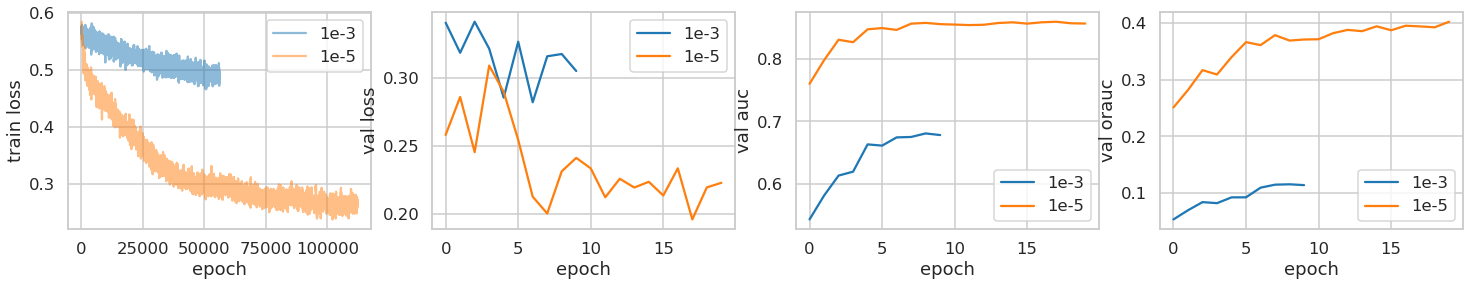

In [21]:
file_prefixes = [
                 ('resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-3'),
                 ('resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-5'),
                 ]
titles = [ 
        '1e-3', '1e-5']
performance = learning_curves_comparsion(file_prefixes, titles)

In [22]:
performance

,pretrain-exp,exp,weight init,title,auc,prauc
0,resnet18_imagenet_supervised,train_nyu_ffdm_screening/eval/nyu_readerstudy_...,1e-3,1e-3,0.68096,0.11601
1,resnet18_imagenet_supervised,train_nyu_ffdm_screening/eval/nyu_readerstudy_...,1e-5,1e-5,0.85888,0.40159


##  multi-instance-attention cross-modal swav pretrainined
* nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/
    - 1e-3 [200 epochs] [logs need to be combined] [training:  nyu_ffdm_screening]
    - 1e-2 [100 epochs] [training:  nyu_ffdm_screening]
    - 1e-5 [100 epochs] [training:  nyu_ffdm_screening]

* nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head
    - 1e-3 [200 epochs] [logs need to be combined] [training:  nyu_ffdm_screening]
    - 1e-2 [100 epochs] [training:  nyu_ffdm_screening]
    

1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-2/20220514_130808.log.json 1
1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220517_135111.log.json 201
2 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220516_225101.log.json 101
3 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220514_000650.log.json 1
1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-5/20220514

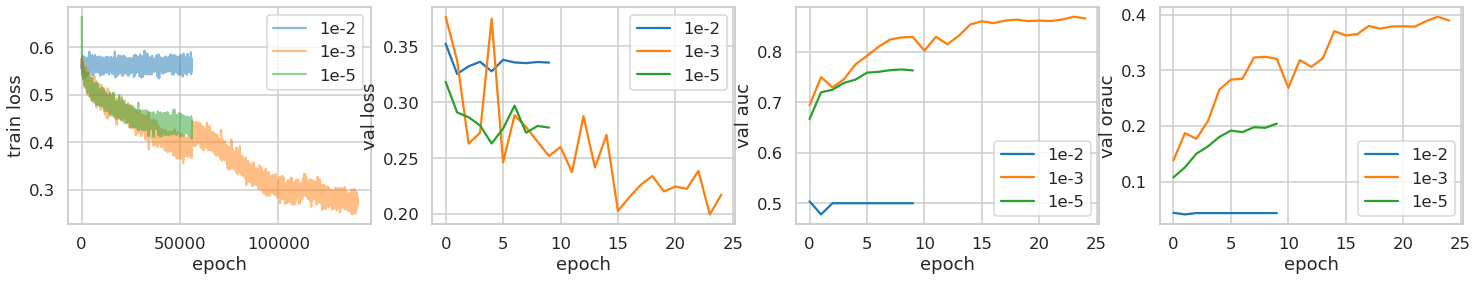

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/,1e-2,1e-2,0.50386,0.04421
1,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/,1e-3,1e-3,0.87022,0.39643
2,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/,1e-5,1e-5,0.76556,0.20449


In [23]:
file_prefixes = [
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/', '1e-2'),
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/', '1e-3'),
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/', '1e-5'),
                 ]
titles = ['1e-2', '1e-3', '1e-5']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-2/20220514_144123.log.json 1
1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3/20220517_135053.log.json 151
2 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3/20220516_131623.log.json 101
4 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3/20220514_134007.log.json 1


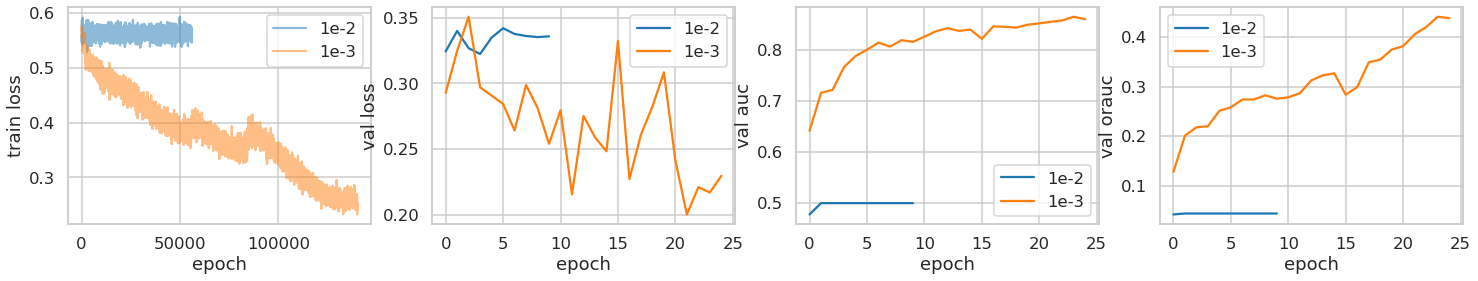

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/pretrained_head/,1e-2,1e-2,0.50000,0.04373
1,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/pretrained_head/,1e-3,1e-3,0.86452,0.44094


In [24]:
file_prefixes = [
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/pretrained_head/', '1e-2'),
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/pretrained_head/', '1e-3'),
                 ]
titles = ['1e-2', '1e-3']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220518_132725.log.json 251
2 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220517_135111.log.json 201
3 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220516_225101.log.json 101
4 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/20220514_000650.log.json 1
1 /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_

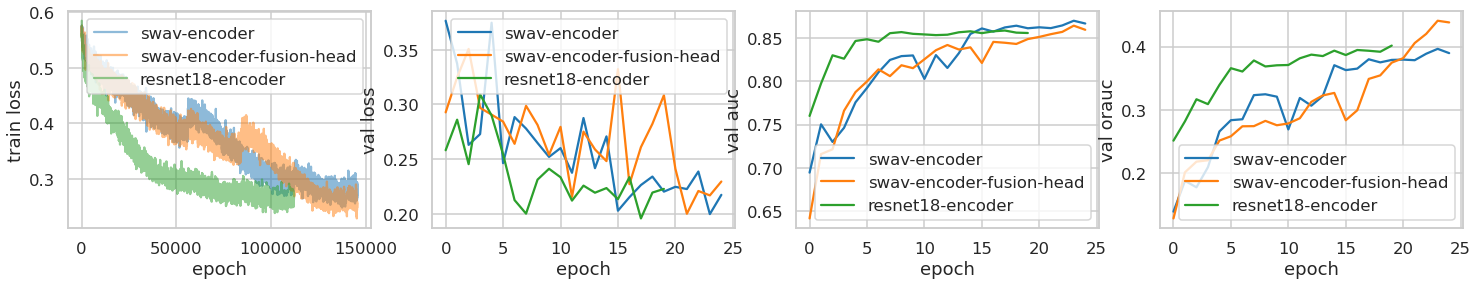

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/,1e-3,swav-encoder,0.87022,0.39643
1,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/pretrained_head/,1e-3,swav-encoder-fusion-head,0.86452,0.44094
2,resnet18_imagenet_supervised/train_nyu_ffdm_sc...,nyu_readerstudy_ffdm/,1e-5,resnet18-encoder,0.85888,0.40159


In [29]:
file_prefixes = [
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/', '1e-3'),
                 ('nyu_ffdm_screening_supervised/eval_nyu_readerstudy', 'swav_resnet18_milatten1_batch128/pretrained_head/', '1e-3'),
                 ('resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval', 'nyu_readerstudy_ffdm/', '1e-5'),
                 ]
titles = ['swav-encoder', 'swav-encoder-fusion-head', 'resnet18-encoder']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

In [26]:
"""
export PREFIX='/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm'
export SAVE='/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/ffdm'
bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/latest.pth \
    --work-dir $SAVE/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3 \
    --launcher="pytorch" \
    --breast 

bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3/latest.pth \
    --work-dir $SAVE/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3 \
    --launcher="pytorch" \
    --breast 
    
bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5/latest.pth \
    --work-dir $SAVE/resnet18_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5 \
    --launcher="pytorch" --breast  \
    --cfg-options data.val.data_source.color_type='color' model.backbone.in_channels=3
"""

'\nexport PREFIX=\'/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm\'\nexport SAVE=\'/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/ffdm\'\nbsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch     --master_addr="127.0.0.1"     --master_port=29500     --nproc_per_node=1     tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py     $PREFIX/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3/latest.pth     --work-dir $SAVE/nyu_ffdm_screening_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3     --launcher="pytorch"     --breast \n\nbsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch     --master_addr="127.0.0.1"     --master_port=29500     --nproc_per_node=1     tools/test.py configs/benchmarks/classification/nyubreast/ffdm/

In [30]:
save_prefix = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/ffdm'
results = []
for (path, exp, winit), title  in zip(file_prefixes, titles):

    logs_sorted_by_time = sorted(glob.glob(os.path.join(save_prefix, f'{path}/{exp}{winit}', '*.log')))
    if len(logs_sorted_by_time)>0:  
        with open(logs_sorted_by_time[-1]) as f:
            lines = f.readlines()
        scores = {'title': title}
        for line in lines:
            col, item = line.split('-')[-1][:-1].strip().split(':')
            scores.update({col: float(item)})
        results.append(scores)

performance.merge(pd.DataFrame(results), on='title')

,pretrain-exp,exp,weight init,title,auc,prauc,head4_auc,head4_prauc
0,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/,1e-3,swav-encoder,0.87022,0.39643,0.900,0.545
1,nyu_ffdm_screening_supervised/eval_nyu_readers...,swav_resnet18_milatten1_batch128/pretrained_head/,1e-3,swav-encoder-fusion-head,0.86452,0.44094,0.899,0.562
2,resnet18_imagenet_supervised/train_nyu_ffdm_sc...,nyu_readerstudy_ffdm/,1e-5,resnet18-encoder,0.85888,0.40159,0.883,0.501
